In [26]:
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import os
import time 
import pickle

Generate from Ze time series dataset 

In [2]:
import itertools

def get_periodic_coordinates(coord, size):
    """
    Generate all coordinates within a cubic domain considering periodic boundary conditions.
    
    Parameters:
        coord (pandas dataframe): A pandas dataframe containing the columns (x, y, z) of a point.
        size (int): The size of the cubic domain along each axis.
    Returns:
        list: A list of tuples containing all coordinates within the cubic domain.
    """
    ### Keep copy of original dataframe and copy for each periodic bc shift ###
    coord_copy = [coord.copy() for _ in range(27)]
    stacked_df = pd.concat(coord_copy, axis=0)
    stacked_df = stacked_df.reset_index(drop=True, inplace=False)
    
    # Get coordinates ###
    if isinstance(coord, pd.DataFrame):
        coord = coord[["x","y","z"]].values

    # Generate all combinations of displacements (-1, 0, 1) along each axis
    displacements = list(itertools.product([-1, 0, 1], repeat=3))

    # Generate all coordinates by applying periodic boundary conditions
    tp_coordinates = list()
    
    for dx, dy, dz in displacements:
          
        temp = list()
        
        for i in range(len(coord)):
            
            x, y, z = coord[i,0],coord[i,1],coord[i,2]
            
            new_x = x + dx*size
            new_y = y + dy*size
            new_z = z + dz*size

            temp.append((new_x,new_y,new_z))
            
        tp_coordinates.append( np.array(temp) )
    
    stacked_df[["x","y","z"]] = np.vstack(tp_coordinates) 
    
    return np.vstack(tp_coordinates),stacked_df

In [3]:
def group_time_series_data(time_series_data):
    
    """
    Groups the data based on case_ID and time 
    
    Parameters:
       time_series_data (pandas dataframe) : obtained from Ze's final data directory 
    Returns:
        list: A list of pandas dataframes each with a unique case id and time-stamp
    """
    ### load raw data from ze time series data ###
    pd_list  = list()
    
    for (col1_val, col2_val), group in time_series_data.groupby(['case_ID', 'time']):
    
        pd_list.append(group)
    
    return pd_list

In [4]:
def generate_nearest_neighbor_data(time_series_data):

    """
    Wrapper function (in some sense, can be condensed more)to do the data generation 
    
    Parameters:
       time_series_data (pandas dataframe) : obtained from Ze's final data directory 
    Returns:
        list: A list of pandas dataframes each with a unique case id and time-stamp
    """
    
    pd_list = group_time_series_data(time_series_data)
    
    nearest_neighbor_data = list()
    nearest_neighbor_data_extra = list()
    scalar_data = list()
    
    ### Loop over different groups ###
    
    for i in range(len(pd_list)):
        
        print("Currently on case_time subgroup : ",str(i+1))
        tp_particles,stacked_df = get_periodic_coordinates(pd_list[i],5)
        tree = cKDTree(tp_particles)
        
        ### Loop over all particles in a group and getting the nearest neighbors ###
        idx = np.stack([ tree.query(pd_list[i].iloc[j][["x","y","z"]].values,16)[1] for j in range(len(pd_list[i])) ])
        nearest_neighbor_data.append(tp_particles[idx])
        
        ### merging nodal data to the coordinates ###
        nearest_neighbor_data_extra.append(merge_columns_to_pandas_list(tp_particles[idx],"local_Re",stacked_df))
        
        ### Getting the scalar data ###
        scalar_data.append( pd_list[i][["Density_ratio","glb_phi","glb_Re","local_Re","Drag"]] )
        clear_output(wait=True)
    
    ### Populate graph and scalar lists ###
    nearest_neighbor_data = np.stack(nearest_neighbor_data)
    nearest_neighbor_data_extra = np.stack(nearest_neighbor_data_extra)
    
    nearest_neighbor_data = nearest_neighbor_data.reshape(nearest_neighbor_data.shape[0]*nearest_neighbor_data.shape[1]
                                           ,nearest_neighbor_data.shape[2]*nearest_neighbor_data.shape[3])
    
    nearest_neighbor_data_extra = nearest_neighbor_data_extra.reshape(nearest_neighbor_data_extra.shape[0]*nearest_neighbor_data_extra.shape[1]
                                           ,nearest_neighbor_data_extra.shape[2]*nearest_neighbor_data_extra.shape[3])
    
    scalar_data = np.stack(scalar_data)
    scalar_data = scalar_data.reshape(scalar_data.shape[0]*scalar_data.shape[1],scalar_data.shape[2])    
    
    ### change code if you want to return nearest_neighbor_data or extra ### 
    return np.concatenate( (nearest_neighbor_data_extra,scalar_data) ,axis=1)

In [5]:
def merge_columns_to_pandas_list(nearest_neighbor_data,variable_list,master_dataframe):

    """ given a list of pandas dataframe with the x,y,z locations and re and phi ,this function will
        merge each pandas dataframe from the list with the master dataframe with all the columns  
    """

    joined =[pd.DataFrame(nearest_neighbor_data[i],columns=["x","y","z"]) for i in range(len(nearest_neighbor_data))]

    for i in range(len(joined)):
        
        temp = copy.deepcopy(joined[i])
        add = pd.merge(temp,master_dataframe,how="inner",on=['x','y','z'],sort=False)[variable_list]
        joined[i] = pd.concat([temp,add], axis=1)
        
    return joined

In [6]:
def modify_nearest_neighbor_data(nearest_neighbor_data,pd_list):
    
    """
    This function takes nearest neighbor data and the pd_list and it will return a pandas dataframe with each row
    having the particle ID (integer), the time step (integer) and the case (integer) of which the particle is a part of
    ,and the remaining columns will be the nearest neighbor row itself.
    """
    case_column = np.stack( [ pd_list[i]["case_ID"].values for i in range(len(pd_list)) ] ).flatten()
    particle_id_column = np.stack( [ np.arange(pd_list[i].shape[0])+1 for i in range(len(pd_list)) ] ).flatten()
    time_column = np.stack( [ pd_list[i]["time"].values for i in range(len(pd_list)) ] ).flatten()
    
    ### Combining columns with nearest_neighbor_data ###
    nearest_neighbor_data_modified = np.concatenate( (case_column[:,None],particle_id_column[:,None],time_column[:,None]
                ,nearest_neighbor_data),axis=1 )
    
    return nearest_neighbor_data_modified

In [7]:
   def generate_temporally_history_datasets_for_single_group(single_df,history_length,sampling_rate):
        
        """
        performs the data generation for a single group
        """
        start_index = history_length*sampling_rate
        
        for i in range(start_index,len(single_df)):
            
            extracted_sequences = [ [single_df.iloc[k - j * sampling_rate] for j in range(history_length + 1)]
                                    for k in range(start_index, len(single_df)) ]
                              
        extracted_sequences = [pd.concat(series_list, axis=1).T for series_list in extracted_sequences]
        
        return extracted_sequences

In [8]:
def generate_temporally_history_datasets_for_single_group(single_df, history_length, sampling_rate):
    """
    Performs the data generation for a single group
    """
    start_index = history_length * sampling_rate
    num_rows = len(single_df)
    indices = []

    # Create a list of indices to extract
    for i in range(start_index, num_rows):
        indices.append([i - j * sampling_rate for j in range(history_length + 1)])
    
    
    # Flatten the list of indices
    flat_indices = [index for sublist in indices for index in sublist]

    # Use iloc to extract all needed rows at once
    extracted_sequences = single_df.iloc[flat_indices]

    # Reshape the dataframe to have the desired format
    reshaped_data = []
    for i in range(0, len(flat_indices), history_length + 1):
        reshaped_data.append(extracted_sequences.iloc[i:i + history_length + 1].reset_index(drop=True))
    
    return reshaped_data

In [9]:
def generate_temporally_history_datasets(grouped_dfs,history_length=3,sampling_rate=2):
    
    """ 
    Given a list of pandas dataframes where each element is the temporal trajectory of one particle
    , this functions operates on each of the elements and gives historical time data points, for instance if
    the trajectory has 100 time steps, and the history is length is 3 with the sampling rate being 2. The first
    data point will be of timestep 1-3-5 and the label would be the drag from timestep 5, second datapoint would be 
    2-4-6 and the label would be the drag at 6 and so on.
    """
    
    extracted_sequences = list()
    
    for i in range(len(grouped_dfs)):
        
        print("Currently on particle number : ",str(i+1))
        
        extracted_sequences.append( generate_temporally_history_datasets_for_single_group( grouped_dfs[i] , history_length 
                                                                                , sampling_rate) )
        clear_output(wait=True)
    
    reversed_extracted_sequences = [[df.iloc[::-1].reset_index(drop=True) for df in sublist] for sublist in extracted_sequences]
    
    return reversed_extracted_sequences  

In [10]:
def concat_over_all_levels(data):
    
    # Flatten the list of lists into a single list of DataFrames
    flattened_list = [df for sublist in data for df in sublist]

    # Concatenate all DataFrames in the flattened list into a single DataFrame
    combined_dataframe = pd.concat(flattened_list, ignore_index=True)
    
    return combined_dataframe

In [11]:
def rename_columns(nearest_neighbor_data_modified):
    
    ### Define new column names ###
    new_column_names = {0: 'case', 1: 'particle_ID', 2: 'time',3:"x_poi",4:"y_poi",5:"z_poi",6:"local Re"}

    for i in range(15):

        new_column_names[len(new_column_names)] = "x_" + str(i + 1)
        new_column_names[len(new_column_names)] = "y_" + str(i + 1)
        new_column_names[len(new_column_names)] = "z_" + str(i + 1)
        new_column_names[len(new_column_names)] = "local_Re_" + str(i + 1)

    new_column_names[len(new_column_names)] = "density_ratio"
    new_column_names[len(new_column_names)] = "glb_phi"
    new_column_names[len(new_column_names)] = "glb_Re"
    new_column_names[len(new_column_names)] = "local_Re"
    new_column_names[len(new_column_names)] = "Drag"
    
    return nearest_neighbor_data_modified.rename(columns=new_column_names, inplace=True)

In [12]:
# def scale_xyz_columns_and_others(df):
#     # Initialize the MinMaxScaler
#     scaler = MinMaxScaler()

#     # Iterate over each column in the dataframe
#     for col in df.columns:
#         if col.startswith('x_') or col.startswith('y_') or col.startswith('z_'):
#             # Apply the custom scaling operation to each column that starts with 'x_', 'y_', or 'z_'
#             df[col] = (df[col] - (-5)) / (10 - (-5))
#         else:
#             # Collect the other columns to be scaled using MinMaxScaler
#             df[col] = scaler.fit_transform(df[[col]])
            
#     return df

In [13]:
def scale_xyz_and_other_columns(train_df, test_df):
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    train_df_copy,test_df_copy = train_df.copy(), test_df.copy()
    
    # Iterate over each column in the dataframe
    for col in train_df_copy.columns:
        if col.startswith('x_') or col.startswith('y_') or col.startswith('z_'):
            # Apply the custom scaling operation to each column that starts with 'x_', 'y_', or 'z_'
            train_df_copy[col] = (train_df_copy[col] - (-5)) / (10 - (-5))
            test_df_copy[col] = (test_df_copy[col] - (-5)) / (10 - (-5))
        else:
            # Fit the scaler on the train data and transform both train and test data
            train_df_copy[col] = scaler.fit_transform(train_df_copy[[col]])
            test_df_copy[col] = scaler.transform(test_df_copy[[col]])
            
    return train_df_copy, test_df_copy

In [14]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plot_3d_trajectory(trajectory,color="red",title="plot",limits=[-5,10],middle_cube="big"):
    """
    Plots a 3D trajectory given a NumPy array with x, y, z coordinates.

    Parameters:
    - trajectory: A NumPy array of shape (n, 3), where n is the number of timesteps,
                  and each row represents the [x, y, z] coordinates at a timestep.
    """
    # Ensure the input is a NumPy array
    trajectory = np.array(trajectory)
    
    # Check if the input has the correct shape
#     if trajectory.shape[1] != 3:
#         raise ValueError("Input array must have shape (n, 3) where n is the number of timesteps.")
    
    # Extract x, y, z coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    z = trajectory[:, 2]
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory
    ax.scatter(x[0], y[0], z[0], label='3D trajectory',c="red",s=100)
    ax.scatter(x[1:], y[1:], z[1:], label='3D trajectory',c=color,s=25,alpha=0.25)
    
    # Add labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add title
    ax.set_title(title)
    
    # set limits
    ax.set_xlim([limits[0],limits[1]])
    ax.set_ylim([limits[0],limits[1]])
    ax.set_zlim([limits[0],limits[1]])
    
    # Show legend
    ax.legend()
    
    if middle_cube=="big":
        # Create vertices for the cube
        vertices = [[0, 0, 0], [5, 0, 0], [5, 5, 0], [0, 5, 0],
                [0, 0, 5], [5, 0, 5], [5, 5, 5], [0, 5, 5]]
    
    if middle_cube=="small":
        
        # Create vertices for the cube
        vertices = [[0.333, 0.333, 0.333], [0.666, 0.333, 0.333], [0.666, 0.666, 0.333], [0.333, 0.666, 0.333],
                [0.333, 0.333, 0.666], [0.666, 0.333, 0.666], [0.666, 0.666, 0.666], [0.333, 0.666, 0.666]]
    
    # Define the 6 faces of the cube
    faces = [[vertices[j] for j in [0, 1, 2, 3]],
             [vertices[j] for j in [4, 5, 6, 7]], 
             [vertices[j] for j in [0, 1, 5, 4]], 
             [vertices[j] for j in [2, 3, 7, 6]], 
             [vertices[j] for j in [1, 2, 6, 5]], 
             [vertices[j] for j in [4, 0, 3, 7]]]
    
    # Create a Poly3DCollection for the cube
    cube = Poly3DCollection(faces, alpha=0.1, facecolors='cyan')
    
    
    ax.add_collection3d(cube)
    
    # Show the plot
    plt.show()

In [15]:
# ### Read data ###
experiment = "rho2_10percent_Re10"
time_series_data = pd.read_csv("../ze_time_series_data_raw/"+experiment+".dat")

pd_list = group_time_series_data(time_series_data)
nearest_neighbor_data = generate_nearest_neighbor_data(time_series_data)

### add particle id, case and time column to the dataset ###
nearest_neighbor_data_modified = modify_nearest_neighbor_data(nearest_neighbor_data,pd_list)
nearest_neighbor_data_modified = pd.DataFrame(nearest_neighbor_data_modified)
save=True

Currently on case_time subgroup :  564


In [16]:
### splitting the data such that each grouped df is the trajectory of a single particle across all cases ###

### Renaming the columns
rename_columns(nearest_neighbor_data_modified)

### each element of grouped_dfs is a particle and its trajectory ###
nearest_neighbor_data_grouped = nearest_neighbor_data_modified.groupby(["case","particle_ID"])
grouped_dfs = [group for _, group in nearest_neighbor_data_grouped]

### IMPORTANT : generating the sequnetial data ###
history_length = 3
sampling_rate=2
extracted_sequences  = generate_temporally_history_datasets(grouped_dfs,history_length=history_length,sampling_rate=sampling_rate)

Currently on particle number :  48


In [17]:
### For splitting data as train and test ###
### define train/test indices ###
test_particles_id = np.random.randint(0,len(extracted_sequences)-1,7)
train_particles_id =np.setdiff1d(np.arange(len(extracted_sequences)),test_particles_id)

### extracting the train and test datasets ###
train_data_pd = concat_over_all_levels([extracted_sequences[i] for i in train_particles_id])
test_data_pd = concat_over_all_levels([extracted_sequences[i] for i in test_particles_id])

In [18]:
### Scaling the data ###
train_data_pd_scaled, test_data_pd_scaled = scale_xyz_and_other_columns(train_data_pd,test_data_pd)

### Reshaping by chunking the data ### 
n_train = (train_data_pd.shape[0]//(history_length+1))
train_data_np_scaled = np.array_split(train_data_pd_scaled.values[:,3:],n_train,axis=0)

n_test = (test_data_pd.shape[0]//(history_length+1))
test_data_np_scaled = np.array_split(test_data_pd_scaled.values[:,3:],n_test,axis=0)

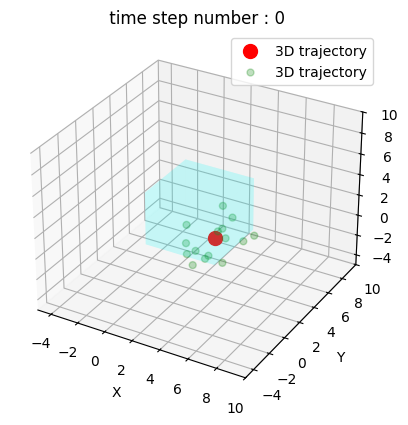

In [19]:
### Plotting the raw data trajectory ###
single_particle_trajectory = grouped_dfs[0].values[:,3:]
k=0

# for i in range(len(single_particle_trajectory)):
for i in range(0,len(single_particle_trajectory),sampling_rate):
    
    if k==4:
        break
    
    title = " time step number : "+str(i)
    plot_3d_trajectory(single_particle_trajectory[i][0:64].reshape(16,4),color="green",title = title,limits=[-5,10])
    clear_output(wait=True)
    time.sleep(0.5)
    break
    
    k=k+1

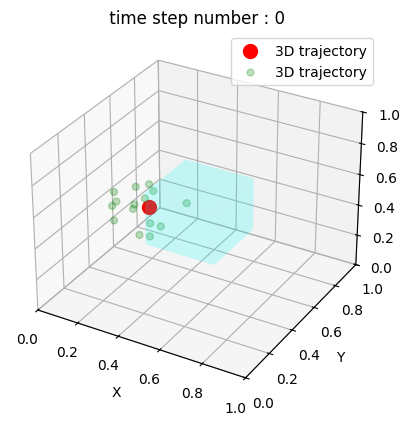

In [20]:
### Plotting the input data trajectory ###

for i in range(10):
    for j in range(4):
        
        plot_3d_trajectory(train_data_np_scaled[0][j][0:64].reshape(16,4),color="green",title = title ,limits=[0,1],middle_cube="small")
        clear_output(wait=True)
        time.sleep(0.5)
        break
        
    break
    

In [24]:
len(train_data_np_scaled),len(test_data_np_scaled)

(11946, 1302)

In [29]:
### Save the list to a pickle file ###
### Train data ###
with open('train_data_np_scaled.pkl', 'wb') as f:
    pickle.dump(train_data_np_scaled, f)
### Test data ### 
with open('test_data_np_scaled.pkl', 'wb') as f:
    pickle.dump(test_data_np_scaled, f)